# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [25]:
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.__version__

'1.5.1'

## Working with street networks

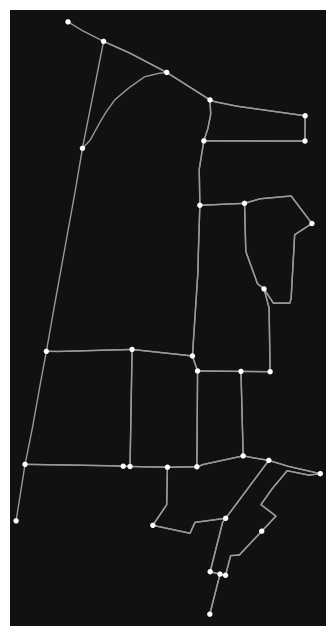

In [26]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("동자동, 남영동, 용산구, 서울, 04320, 대한민국", network_type="drive")
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

OSMnx는 "Piedmont, California, USA" 쿼리를 지오코딩하여 Nominatim API에서 해당 도시의 장소 경계를 검색하고, Overpass API에서 해당 경계 내에서 주행 가능한 거리 네트워크 데이터를 검색하고, 그래프 모델을 구성한 다음, 다음과 같은 토폴로지를 단순화/수정합니다. 노드는 교차로를 나타내고 막 다른 골목과 가장자리는 그들을 연결하는 거리 세그먼트를 나타냅니다. 이 모든 것은 설명서와 이 예제에서 자세히 설명합니다.

OSMnx는 모든 네트워크를 NetworkX `MultiDiGraph` 개체로 모델링합니다. 다음으로 변환할 수 있습니다.
   - 방향이 없는 MultiGraphs
   - (가능한) 평행 에지가 없는 DiGraphs
   - GeoPandas 노드/에지 GeoDataFrames

In [27]:
# convert your MultiDiGraph to an undirected MultiGraph 방향이 없는 멀티그래프로 변환
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges 평행 에지가 없는 디그래프로 변환
D = ox.utils_graph.get_digraph(G)

In [28]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames 그래프를 노드 및 가장자리 GeoPandas GeoDataFrames로 변환할 수 있습니다.
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,geometry
osmid,,,,
436879516,37.554105,126.972964,5,POINT (126.97296 37.55411)
436883130,37.553586,126.974154,4,POINT (126.97415 37.55359)
436883131,37.553830,126.973670,3,POINT (126.97367 37.55383)
2330782424,37.550354,126.972085,3,POINT (126.97209 37.55035)
2330782426,37.550329,126.973678,3,POINT (126.97368 37.55033)


In [29]:
gdf_edges.head()

osmid    name      highway  oneway  reversed  \
u         v          key                                                     
436879516 436883131  0    516163750     후암로    secondary   False      True   
436883130 436883131  0    516163750     후암로    secondary   False     False   
          3800668941 0    224260190  후암로57길  residential   False     False   
          3800668944 0    516163750     후암로    secondary   False      True   
436883131 436883130  0    516163750     후암로    secondary   False      True   

                          length  \
u         v          key           
436879516 436883131  0    69.424   
436883130 436883131  0    50.558   
          3800668941 0    41.304   
          3800668944 0    95.231   
436883131 436883130  0    50.558   

                                                                   geometry  
u         v          key                                                     
436879516 436883131  0    LINESTRING (126.97296 37.55411, 126.97326 37.5...  
436883130 436883131  0    LINESTRING (126.97415 37.55359, 126.97367 37.5...  
          3800668941 0    LINESTRING (126.97415 37.55359, 126.97416 37.5...  
          3800668944 0    LINESTRING (126.97415 37.55359, 126.97421 37.5...  
436883131 436883130  0    LINESTRING (126.97367 37.55383, 126.97415 37.5...

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge ShapeFiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

gdf_nodes가 osmid로 인덱싱되고 gdf_edges가 u, v, key로 멀티 인덱싱되는 한 노드/에지 GeoDataFrames에서 그래프를 생성할 수 있습니다(일반적인 MultiDiGraph 구조를 따름). 이를 통해 그래프 노드/에지 ShapeFiles 또는 GeoPackage 레이어를 GeoDataFrames로 로드한 다음 그래프 분석을 위해 MultiDiGraph로 변환할 수 있습니다.

In [30]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph 노드/에지 GeoPandas GeoDataFrames를 NetworkX MultiDiGraph로 변환
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [31]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

131865.11699016532

In [32]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 34,
 'm': 80,
 'k_avg': 4.705882352941177,
 'edge_length_total': 5298.177000000002,
 'edge_length_avg': 66.22721250000004,
 'streets_per_node_avg': 3.1470588235294117,
 'streets_per_node_counts': {0: 0, 1: 0, 2: 0, 3: 30, 4: 3, 5: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.8823529411764706,
  4: 0.08823529411764706,
  5: 0.029411764705882353},
 'intersection_count': 34,
 'street_length_total': 2967.9959999999996,
 'street_segment_count': 43,
 'street_length_avg': 69.02316279069767,
 'circuity_avg': 1.0388813921359483,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': 26,
 'node_density_km': 257.83922826637894,
 'intersection_density_km': 257.83922826637894,
 'edge_density_km': 40178.76084996116,
 'street_density_km': 22507.817592285282,
 'clean_intersection_density_km': 197.17117455664274}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [33]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.save_graphml(G, filepath="./data/mynetwork.graphml")

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

여기에서 우리는 거리 네트워크를 플로팅하고 상대적인 근접 중심성에 따라 가장자리(거리)에 색상을 지정합니다.

In [34]:
# convert graph to line graph so edges become nodes and vice versa 그래프를 선 그래프로 변환하여 엣지가 노드가 됨 / 반대도 가능
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

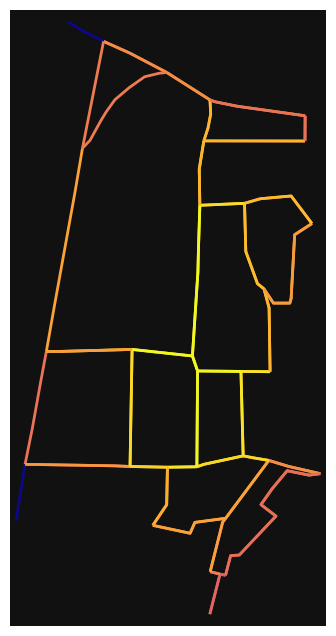

In [35]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="plasma")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [36]:
# impute missing edge speeds and calculate edge travel times with the speed module 누락된 edge 속도 대치 및 속도 모듈로 edge 이동 시간 계산
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

ValueError: this graph's edges have no preexisting `maxspeed` attribute values so you must pass `hwy_speeds` or `fallback` arguments.

In [37]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=-122.245846, Y=37.828903)
dest = ox.distance.nearest_nodes(G, X=-122.215006, Y=37.812303)

c:\Users\Uh\AppData\Local\Programs\Python\Python311\Lib\site-packages\osmnx\distance.py:416: UserWarning: The attribute 'travel_time' is missing or null on some edges.
  _verify_edge_attribute(G, weight)


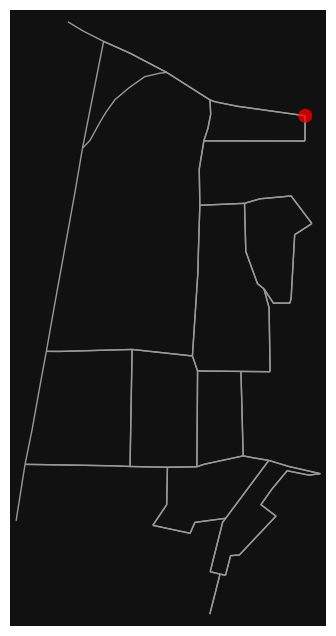

In [38]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [39]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.route_to_gdf(G, route)["length"]
round(sum(edge_lengths))

ValueError: graph contains no edges

In [40]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x))

0

You can add elevation attributes to your graph's nodes automatically with the `elevation` module, using either local raster files or the Google Maps Elevation API.

In [41]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key

    G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
except ImportError:
    print("You need a google_elevation_api_key to run this cell.")

You need a google_elevation_api_key to run this cell.


Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

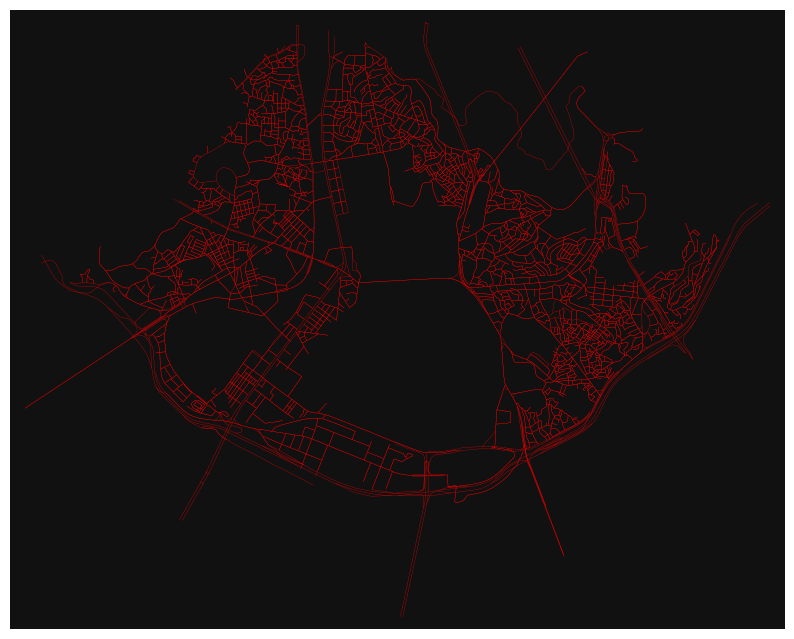

In [42]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "용산구", "state": "서울", "country": "대한민국"}
G = ox.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="r", edge_linewidth=0.2)

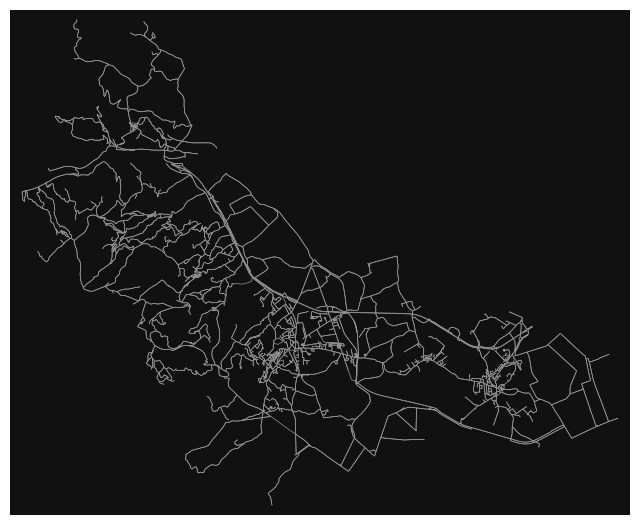

In [43]:
# you can get networks anywhere in the world
G = ox.graph_from_place("Sinalunga, Italy", network_type="all")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

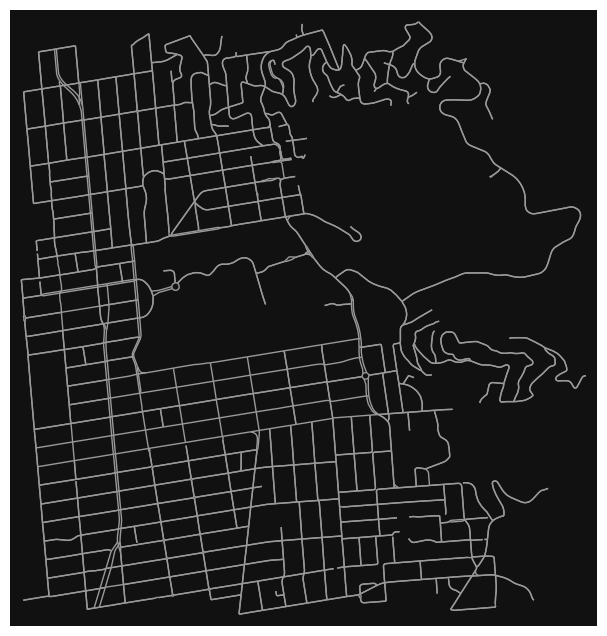

In [44]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want

# 또는 주소, 좌표, 경계 상자 또는 사용자 지정 다각형으로 네트워크를 가져옵니다.
# ...OSM이 원하는 장소에 폴리곤을 가지고 있지 않을 때 유용합니다.
wurster_hall = (37.870605, -122.254830)
one_mile = 1609  # meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

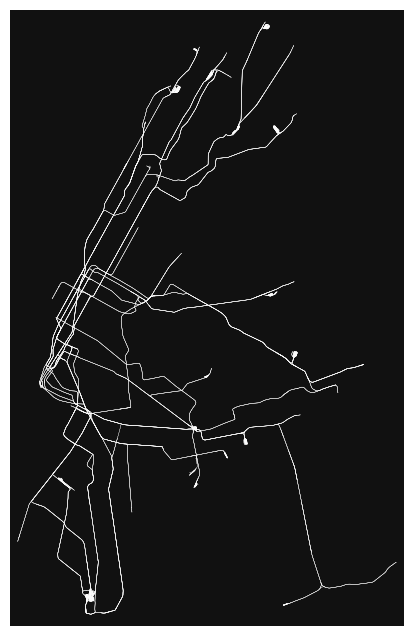

In [45]:
# get NY subway rail network
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

## Get any geospatial features' geometries and attributes

Use the `features` module to download any OSM features, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.features). For more usage examples of downloading geospatial features from OSM, see [this notebook](16-download-osm-geospatial-features.ipynb).

In [46]:
# get all building footprints in some neighborhood
place = "SoHo, New York, NY"
tags = {"building": True}
gdf = ox.features_from_place(place, tags)
gdf.shape

(847, 84)

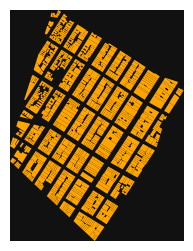

In [47]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

See the other notebooks for more examples of visualization with OSMnx.

In [48]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.features_from_place(place, tags)
gdf.shape

(20, 33)